<a href="https://colab.research.google.com/github/jade0520/DeepLearning_FromScratch/blob/master/2nd/2_CH02_Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 말뭉치 전처리

In [ ]:
text = 'You say goodbye and I say hello.'

text = text.lower()

text = text.replace('.',' .') # 마침표 분리 위함

print(text)

you say goodbye and i say hello .


In [ ]:
words = text.split(' ') #공백을 기준으로 분할

print(words)

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


ID 부여

In [ ]:
#딕셔너리 선언
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:      # word_to_id 에 포함 되어있지 않을 경우 
        new_id = len(word_to_id)    # word_to_id의 길이를 id로 한다. (즉 들어오는 순서대로 id를 가진다.)
        word_to_id[word] = new_id   # word_to_id에 word 를 key로 하여 new_id를 value로 연결
        id_to_word[new_id] = word   # id_to_word에 new_id를 key로 하여 word로 연결

print(word_to_id)
print(id_to_word)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [ ]:
print(word_to_id['hello'])
print(id_to_word[1])

5
say


In [ ]:
import numpy as np

corpus_ = [word_to_id[w] for w in words]    #words안의 원소를 뽑아 word_to_id의 key로 삼고 value를 corpus에 저장한다.
corpus_ = np.array(corpus_)                  #저장한 corpus를 배열로 변환
print(corpus_)

[0 1 2 3 4 1 5 6]


함수로 정의

In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.',' .')

    words = text.split(' ') 

    word_to_id = {}
    id_to_word = {}

    for word in words:
      if word not in word_to_id:      
          new_id = len(word_to_id)    
          word_to_id[word] = new_id   
          id_to_word[new_id] = word 

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

# 말뭉치로 부터 동시발생 행렬을 만드는 함수 

 단어를 벡터로 표현한다.

In [ ]:
def create_co_matrix(corpus, vcab_size, window_size = 1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size,vocab_size),dtype = np.int32)

  # corpus size = n
  for idx, word_id in enumerate(corpus):
    for i in range(1,window_size+1):
      #검사할 주변 맥락의 인데스 설정
      left_idx = idx - i
      right_idx = idx + i

      #문장을 벗어나지 않은 경우, 맥락에 해당하는 단어의 id를 받고 매트릭스에 word_id에 해당하는 행에 1을 추가한다. 
      # 0은 포함 가능
      if left_idx >= 0 :
        left_word_id = corpus[left_idx]
        co_matrix[word_id,left_word_id] += 1

      # 사이즈는 넘어가면 안된다.: 인덱스 시작이 0이므로
      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id,right_word_id] += 1

  return co_matrix

In [ ]:
vocab_size = len(word_to_id)
matrix = create_co_matrix(corpus_,vocab_size , 1)
print(matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


벡터간 유사도

# 벡터간 유사도

코사인 유사도를 이용한다. 

두 벡터의 내적에 L2를 나누면 두 벡터 사이각에 대한 코사인 값이 됨을 이용


In [ ]:
def cos_similarity(x,y,eps = 1e-8): #0으로 나누기 방지용 작은 값
    nx = x / np.sqrt(np.sum(x**2) + eps)  #x의 정규화
    ny = y / np.sqrt(np.sum(y**2) + eps)  #y의 정규화

    #앞선 변수의 분모들은 상수가 되므로, 먼저 나눈 뒤 내적해도 괜찮다.
    return np.dot(nx,ny)

벡터간 유사도 구하기

In [ ]:
import sys
sys.path.append('..')
text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)

c0 = C[word_to_id['you']] #'you'의 벡터
c1 = C[word_to_id['i']]   #'I'의 벡터

print(cos_similarity(c0,c1))


0.7071067758832467


유사 단어의 랭킹 표시

In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):
                # query :  데이터베이스에 정보를 요청하는 것
    
    ### 검색어 꺼내기
    # 검색어가 없을 경우. 
    if query not in word_to_id:
        print(f'{query}(을)를 찾을 수 없습니다.')
        return
    # 검색어가 있을 경우,
    print('\n[query]'+query)
    # 쿼리에 해당하는 단어의 ID를 꺼내어 벡터를 구한다.
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    ### 코사인 유사도 계산 : 쿼리에 해당하는 단어와 다른 모든 단어들 사이의 코사인 유사도를 계산.
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
      similarity[i] = cos_similarity(word_matrix[i], query_vec)

    ### 코사인 유사도를 기준으로 내림차순으로 출력]
    # count 왜 있는지 확인
    count = 0

    # argsort()는 오름차순을 위한 함수이므로, 부호를 바꾸어 내림차순으로 출력하도록 한다.
    for i in (-1 * similarity).argsort() :
      # 쿼리에 해당하는 단어의 경우 출력 하지 않고 넘어간다.
      if id_to_word[i] == query:
          continue
      print(f'{id_to_word[i]} : {similarity[i]}')

      count +=1
      #출력 횟수가 top 이 되면 출력을 끝낸다.
      if count >= top:
        return

In [ ]:
text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)

most_similar('you',word_to_id, id_to_word, C, top = 5)


[query]you
hello : 0.9999999900000001
goodbye : 0.7071067758832467
i : 0.7071067758832467
say : 0.0
and : 0.0


# 통계기반 기법의 개선

> 상호 정보량


PMI 

In [ ]:
def ppmi(C, verbose=False, eps = 1e-8):
            #:진행상황 출력 여부

    
    M = np.zeros_like(C, dtype=np.float32)  # PPMI의 결과를 출력할 행렬
    N = np.sum(C)                           # 전체 단어 개수 N : 그런데 동시 발생 행렬 C는 윈도우 크기에 따라 달라지는 것이 아닌가?? . 
    S = np.sum(C, axis=0)                   # 각 단어별 발생 횟수
    total = C.shape[0] * C.shape[1]         # 
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) ) # 동시 발생 횟수가 0인 경우 -inf가 된다.
            M[i, j] = pmi

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

Test : 

In [ ]:
import numpy as np

text = 'You say goodbye and I say  hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 0]]
--------------------------------------------------
PMI
[[-inf   2. -inf -inf -inf -inf -inf -inf]
 [  2. -inf   1. -inf   1.   1. -inf -inf]
 [-inf   1. -inf   2. -inf -inf -inf -inf]
 [-inf -inf   2. -inf   2. -inf -inf -inf]
 [-inf   1. -inf   2. -inf -inf -inf -inf]
 [-inf   1. -inf -inf -inf -inf   2. -inf]
 [-inf -inf -inf -inf -inf   2. -inf   3.]
 [-inf -inf -inf -inf -inf -inf   3. -inf]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


PPMI 양의 상호 정보량


: 동시발생 횟수가 0이면 -inf 로 가는 것 방지 및 음수의 경우 0으로 대체

In [ ]:
def ppmi(C, verbose=False, eps = 1e-8):

    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps) ##작은 수 eps가 있도록 한다
            M[i, j] = max(0, pmi)     #양수

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [ ]:
text = 'You say goodbye and I say  hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0. 2. 0. 0. 0. 0. 0. 0.]
 [2. 0. 1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 2. 0. 0. 0. 0.]
 [0. 0. 2. 0. 2. 0. 0. 0.]
 [0. 1. 0. 2. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 2. 0. 3.]
 [0. 0. 0. 0. 0. 0. 3. 0.]]


+) 윈도우가 1이 아닐때의 PPMI 행렬


In [ ]:
text = 'You say goodbye and I say  hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)

################# 윈도우 사이즈를 다르게 하면 값이 변하는 코드
C = create_co_matrix(corpus, vocab_size, window_size= 3)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 1 1 0 0 0 0]
 [1 0 2 2 2 1 1 1]
 [1 2 0 1 1 0 0 0]
 [1 2 1 0 1 1 0 0]
 [0 2 1 1 0 1 1 0]
 [0 1 0 1 1 0 1 1]
 [0 1 0 0 1 1 0 1]
 [0 1 0 0 0 1 1 0]]
--------------------------------------------------
PPMI
[[0.    0.485 1.485 1.222 0.    0.    0.    0.   ]
 [0.485 0.    0.748 0.485 0.485 0.    0.07  0.485]
 [1.485 0.748 0.    0.485 0.485 0.    0.    0.   ]
 [1.222 0.485 0.485 0.    0.222 0.485 0.    0.   ]
 [0.    0.485 0.485 0.222 0.    0.485 0.807 0.   ]
 [0.    0.    0.    0.485 0.485 0.    1.07  1.485]
 [0.    0.07  0.    0.    0.807 1.07  0.    1.807]
 [0.    0.485 0.    0.    0.    1.485 1.807 0.   ]]


**??) ** 전체 말뭉치 개수를 나타내는 N이 동시 발생행렬의 모든 요소의 합인 것이 이해가 가지 않는다.

```
   N = np.sum(C)
   pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps) 
```



test

In [ ]:
def ppmi_N (C, verbose=False, eps = 1e-8):

    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps) ##작은 수 eps가 있도록 한다
            print(f'{i},{j} : C[{i}, {j}] * N / (S[{j}]*S[{i}]) = {C[i, j]} * {N} / ({S[j]}*{S[i]}) ')
            M[i, j] = max(0, pmi)     #양수

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

In [ ]:
text = 'You say goodbye and I say  hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi_N(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

0,0 : C[0, 0] * N / (S[0]*S[0]) = 0 * 16 / (1*1) 
0,1 : C[0, 1] * N / (S[1]*S[0]) = 1 * 16 / (4*1) 
0,2 : C[0, 2] * N / (S[2]*S[0]) = 0 * 16 / (2*1) 
0,3 : C[0, 3] * N / (S[3]*S[0]) = 0 * 16 / (2*1) 
0,4 : C[0, 4] * N / (S[4]*S[0]) = 0 * 16 / (2*1) 
0,5 : C[0, 5] * N / (S[5]*S[0]) = 0 * 16 / (2*1) 
0,6 : C[0, 6] * N / (S[6]*S[0]) = 0 * 16 / (2*1) 
0,7 : C[0, 7] * N / (S[7]*S[0]) = 0 * 16 / (1*1) 
1,0 : C[1, 0] * N / (S[0]*S[1]) = 1 * 16 / (1*4) 
1,1 : C[1, 1] * N / (S[1]*S[1]) = 0 * 16 / (4*4) 
1,2 : C[1, 2] * N / (S[2]*S[1]) = 1 * 16 / (2*4) 
1,3 : C[1, 3] * N / (S[3]*S[1]) = 0 * 16 / (2*4) 
1,4 : C[1, 4] * N / (S[4]*S[1]) = 1 * 16 / (2*4) 
1,5 : C[1, 5] * N / (S[5]*S[1]) = 1 * 16 / (2*4) 
1,6 : C[1, 6] * N / (S[6]*S[1]) = 0 * 16 / (2*4) 
1,7 : C[1, 7] * N / (S[7]*S[1]) = 0 * 16 / (1*4) 
2,0 : C[2, 0] * N / (S[0]*S[2]) = 0 * 16 / (1*2) 
2,1 : C[2, 1] * N / (S[1]*S[2]) = 1 * 16 / (4*2) 
2,2 : C[2, 2] * N / (S[2]*S[2]) = 0 * 16 / (2*2) 
2,3 : C[2, 3] * N / (S[3]*S[2]) = 1 * 16 / (2*2) 


벡터 차원의 감소

: 벡터 대부분이 0을 나타내므로 중요하지 않은 것을 개선

>특이 값 분해 (SVD)

you의 동시 발생 행렬:
[0 1 0 0 0 0 0]


you의 PPMI행렬:
[0.    1.807 0.    0.    0.    0.    0.   ]


you의 SVD 결과:
[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


you의 2차원 벡터로 줄인 결과:
[0.341 0.   ]




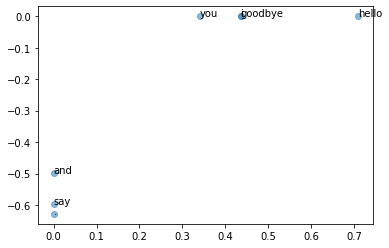

In [ ]:
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

### 벡터차원 감소 SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시

print('you의 동시 발생 행렬:')
print(C[0])
print('\n')

print('you의 PPMI행렬:')
print(W[0])
print('\n')

print('you의 SVD 결과:')
print(U[0])
print('\n')

print('you의 2차원 벡터로 줄인 결과:')
print(U[0,:2])
print('\n')

# 2차원 벡터로 표현 한 후
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

# PTB(Penn Treebank) 데이터 셋

PTB 사용해 보기

In [ ]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 580, done.
remote: Total 580 (delta 0), reused 0 (delta 0), pack-reused 580
Receiving objects: 100% (580/580), 29.81 MiB | 34.10 MiB/s, done.
Resolving deltas: 100% (349/349), done.


In [ ]:
import os
os.chdir('/content/deep-learning-from-scratch-2')

In [ ]:
import sys
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train') #훈련용 데이터 가져오기

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print('id_to_word[33]:', id_to_word[33])
print('id_to_word[68]:', id_to_word[68])
print('id_to_word[100]:', id_to_word[100])
print()
print("word_to_id['study']:", word_to_id['study'])
#print("word_to_id['inha']:", word_to_id['inha']) #  key error 발생
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz
id_to_word[33]: board
id_to_word[68]: filters
id_to_word[100]: unit

word_to_id['study']: 215
word_to_id['lexus']: 7426


PTB 데이터셋 평가 하기

> 통계 기반 기법을 적용하여 데이터 셋을 평가해보자.

> 단어들의 의미를 벡터로 잘 표현하고 있는가?

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100


# ptb 데이터 셋에서 훈련용 데이터 받기 
corpus, word_to_id, id_to_word = ptb.load_data('train')

vocab_size = len(word_to_id)

# 동시 발생 행렬 계산
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)

#PPMI 계산
print('PPMI 계산 ...')
W = ppmi(C, verbose=False)

#SVD 계산
print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

#SVD의 결과를 이용하여 모든 벡터를 wordvec_size 만큼 감소 시킨다.
word_vecs = U[:, :wordvec_size] 

# 주어진 요청에 의해 가장 비슷한 단어 5개를 출력한다.
querys = ['you', 'year', 'car', 'toyota']

for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...


KeyboardInterrupt: ignored